In [1]:
import sys
import os

# Make sure the project root is in sys.path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [13]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from utils.data_preprocessing import load_and_preprocess
from utils.model_utils import save_model, load_model

# Optional display settings
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# 1. Load the Data and Exploratory Data Analysis (EDA)
    - inspect the dataset to understand features and targets

In [3]:
data_path = "../data/creditcard_2023.csv"  # adjust path
df = pd.read_csv(data_path)
df.head()

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,-0.987020,0.293438,-0.941386,0.549020,1.804879,0.215598,0.512307,0.333644,0.124270,0.091202,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,0.140107,1.564246,0.574074,0.627719,0.706121,0.789188,0.403810,0.201799,-0.340687,-0.233984,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,-0.272985,0.659201,0.805173,0.616874,3.069025,-0.577514,0.886526,0.239442,-2.366079,0.361652,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,-0.752581,0.737483,0.592994,0.559535,-0.697664,-0.030669,0.242629,2.178616,-1.345060,-0.378223,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,-1.203171,1.029577,1.439310,0.241454,0.153008,0.224538,0.366466,0.291782,0.445317,0.247237,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


## 1.1 Understand the data - basic checks
- check number of rows/column
- check dataset corruption    
    - unexpected data types
    - any missing values
    - non-sensical values (eg. Age = -1 or 999, Income = “abc)
    - one unique value columns
    - conflicting labeling (could be human labeling error)

In [18]:
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print("\nClass distribution:\n", df['Class'].value_counts())
print("data inf:\n", df.info())
print("data types:\n", df.dtypes)

Dataset shape: (568630, 31)
Columns: ['id', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Missing values:
 id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Class distribution:
 Class
0    284315
1    284315
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568630 entries, 0 to 568629
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      568630 non-null  int64  
 1   V1      568630 non-null  float64
 2   V2

No missing values were found. However, even though XGBoost handles missing values, imputation can help in certain cases:
- missing not at random. 
    - You might creat a "missing" indicator column or use advanced imputation
- large portion of missing values.

In [5]:
# check Non-sensical Values / Out-of-range
print(df.describe(include='all'))

                  id            V1            V2            V3            V4  \
count  568630.000000  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   284314.500000 -5.638058e-17 -1.319545e-16 -3.518788e-17 -2.879008e-17   
std    164149.486122  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min         0.000000 -3.495584e+00 -4.996657e+01 -3.183760e+00 -4.951222e+00   
25%    142157.250000 -5.652859e-01 -4.866777e-01 -6.492987e-01 -6.560203e-01   
50%    284314.500000 -9.363846e-02 -1.358939e-01  3.528579e-04 -7.376152e-02   
75%    426471.750000  8.326582e-01  3.435552e-01  6.285380e-01  7.070047e-01   
max    568629.000000  2.229046e+00  4.361865e+00  1.412583e+01  3.201536e+00   

                 V5            V6            V7            V8            V9  \
count  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05  5.686300e+05   
mean   7.997245e-18 -3.958636e-17 -3.198898e-17  2.109273e-17  3.998623e-17   
std    1.000001e+00  1.000001e+00  1.00000

In [15]:
# Drop duplicates on features + targes
df = df.drop_duplicates()
print(df.shape)

(568630, 31)


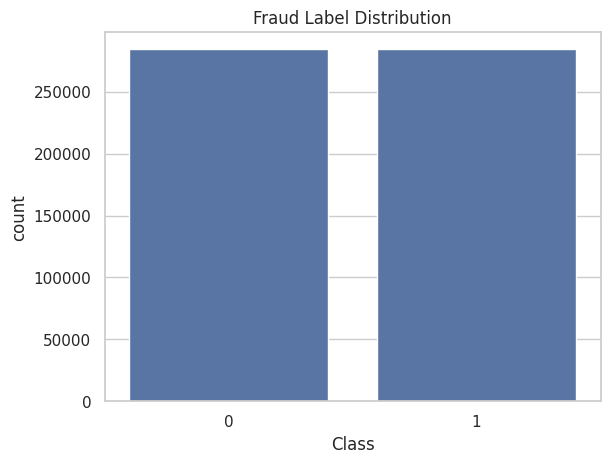

In [6]:
sns.countplot(x='Class', data=df)
plt.title("Fraud Label Distribution")
plt.show()

In [7]:
# Find rows with identical features but different targets
conflicts = df.groupby(list(df.columns.difference(['Class']))).agg({'Class': pd.Series.nunique})
conflicts = conflicts[conflicts['Class'] > 1]
print(conflicts)

Empty DataFrame
Columns: [Class]
Index: []


In [16]:
# Features only
X = df.drop(columns=['Class'])
# Drop ID since it is just an identifier.
X = X.drop(columns=['id'])

constant_cols = X.columns[X.nunique(dropna=False) == 1]
print("Dropped constant columns:", list(constant_cols))
X = X.drop(columns=constant_cols)

# Target only
y = df['Class']

# Optional: check shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

Dropped constant columns: []
Features shape: (568630, 29)
Target shape: (568630,)


## 1.2 Visualize Distribution

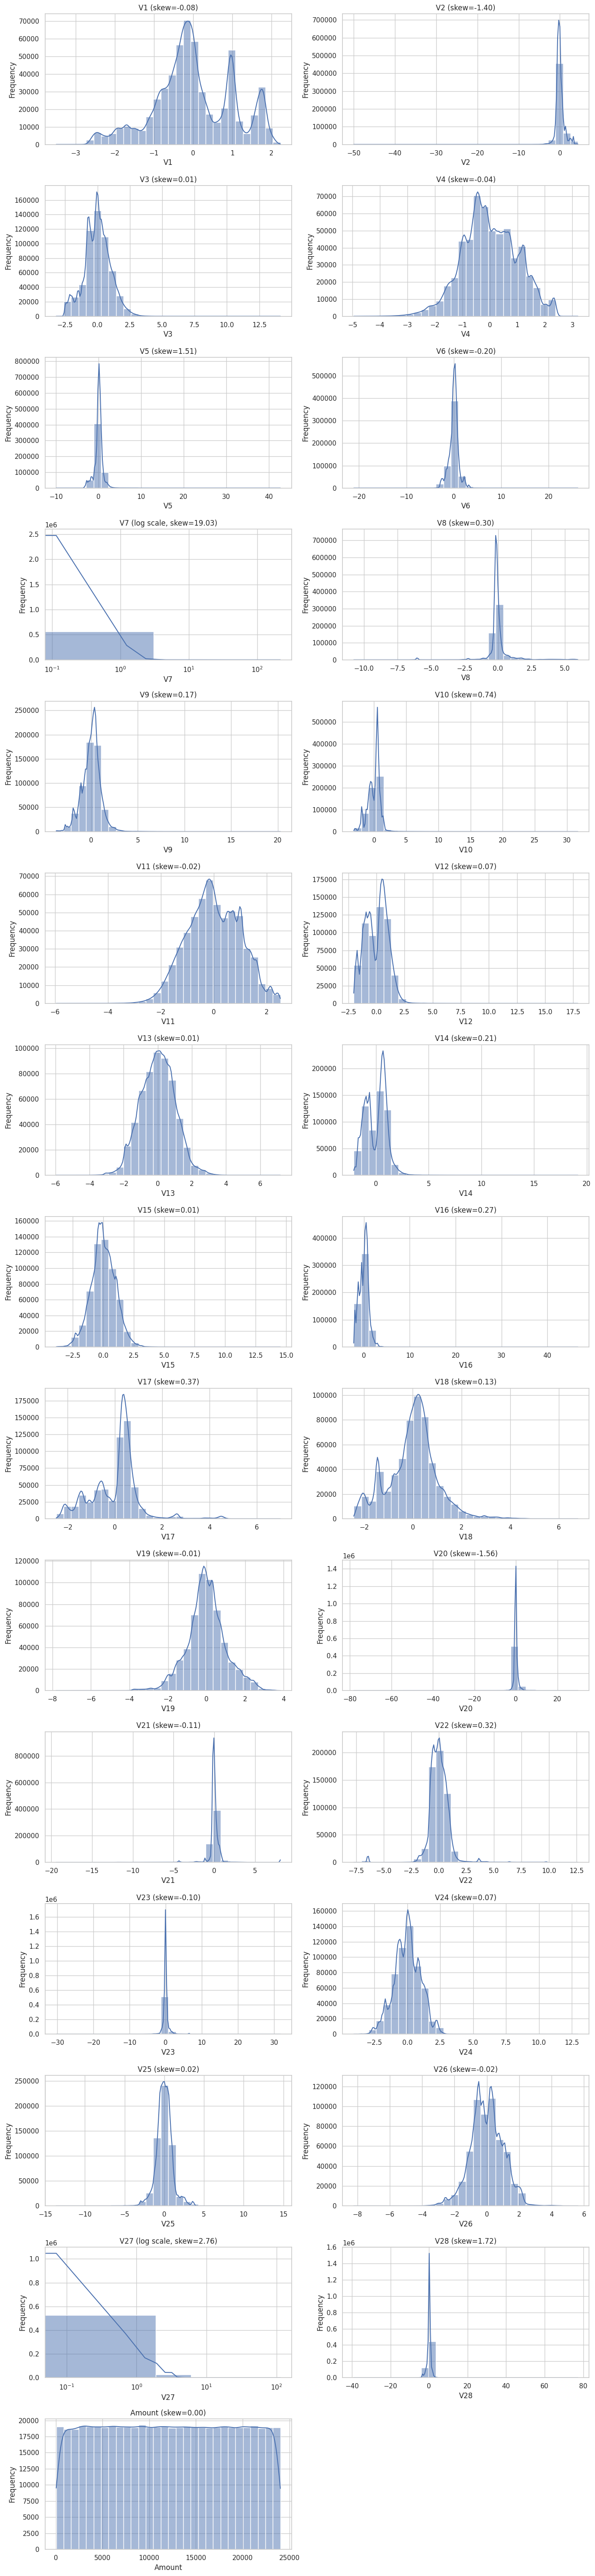

In [17]:
def plot_all_features_grid(df, top_n_categories=20, log_threshold_skew=2):
    num_cols = df.shape[1]
    n_cols = 2
    n_rows = int(np.ceil(num_cols / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows))
    axes = axes.flatten()

    for idx, col in enumerate(df.columns):
        ax = axes[idx]
        if pd.api.types.is_numeric_dtype(df[col]):
            skewness = df[col].skew(skipna=True)
            log_scale = abs(skewness) > log_threshold_skew
            sns.histplot(df[col].dropna(), kde=True, bins=30, ax=ax)
            if log_scale:
                ax.set_xscale('log')
                ax.set_title(f'{col} (log scale, skew={skewness:.2f})')
            else:
                ax.set_title(f'{col} (skew={skewness:.2f})')
            ax.set_xlabel(col)
            ax.set_ylabel('Frequency')
        else:
            vc = df[col].value_counts(dropna=False).head(top_n_categories)
            vc.plot(kind='bar', ax=ax)
            ax.set_title(f'{col} (Top {top_n_categories})')
            ax.set_xlabel(col)
            ax.set_ylabel('Count')

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_all_features_grid(X)  # Set to True to save plots

One dominant category – top category proportion ≥ threshold (e.g., 0.8)

Multiple frequent categories – low-cardinality, no single dominant category

High cardinality – many unique values (≥ threshold, e.g., 20)

In [19]:
def categorize_categorical_features(df, dominance_threshold=0.8, high_cardinality_threshold=20):
    """
    Classify categorical features into:
    - one dominant category
    - multiple frequent categories (low-cardinality)
    - high cardinality
    
    Parameters:
        df (pd.DataFrame): Input DataFrame
        dominance_threshold (float): Top category proportion to consider "dominant"
        high_cardinality_threshold (int): Number of unique categories to consider "high cardinality"
    
    Returns:
        dict: {'one_dominant': [...], 'multi_frequent': [...], 'high_cardinality': [...]}
    """
    one_dominant = []
    multi_frequent = []
    high_cardinality = []

    cat_cols = df.select_dtypes(include='object').columns

    for col in cat_cols:
        n_unique = df[col].nunique(dropna=False)
        counts = df[col].value_counts(normalize=True, dropna=False)
        top_prop = counts.iloc[0]

        if n_unique >= high_cardinality_threshold:
            high_cardinality.append(col)
        elif top_prop >= dominance_threshold:
            one_dominant.append(col)
        else:
            multi_frequent.append(col)

    return {
        'one_dominant': one_dominant,
        'multi_frequent': multi_frequent,
        'high_cardinality': high_cardinality
    }
categorical_features_groups = categorize_categorical_features(X, dominance_threshold=0.8, high_cardinality_threshold=20)
print(categorical_features_groups)

{'one_dominant': [], 'multi_frequent': [], 'high_cardinality': []}


In [20]:
def categorize_numerical_features(df, skew_moderate=0.5, skew_high=1.0):
    """
    Categorize numeric features into symmetric, skewed, heavy-tailed,
    and apply appropriate preprocessing / imputation.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with numeric features
        skew_moderate (float): Threshold for moderate skew
        skew_high (float): Threshold for high skew
    
    Returns:
        dict: Feature categories {'symmetric': [], 'moderate_skew': [], 'heavy_skew': []}
    """
    df_numeric = df.select_dtypes(include=np.number).copy()
    feature_categories = {'symmetric': [], 'moderate_skew': [], 'heavy_skew': []}

    for col in df_numeric.columns:
        skew_val = df_numeric[col].skew()
        
        # Classify feature
        if abs(skew_val) <= skew_moderate:
            category = 'symmetric'
        elif abs(skew_val) <= skew_high:
            category = 'moderate_skew'
        else:
            category = 'heavy_skew'
        
        feature_categories[category].append(col)
    return feature_categories

numerical_features_groups = categorize_numerical_features(X)
print(numerical_features_groups)

{'symmetric': ['V1', 'V3', 'V4', 'V6', 'V8', 'V9', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'Amount'], 'moderate_skew': ['V10'], 'heavy_skew': ['V2', 'V5', 'V7', 'V20', 'V27', 'V28']}


In [21]:
numerical_features = sum(numerical_features_groups.values(), [])
categorical_features = sum(categorical_features_groups.values(), [])

## 1.4 Check for outliers
- Visual inspection (bloxplots, histograms)
- Statistical detection using:
    - IQR (Interquartile Range)
    - Z-score.
    - Isolation Forest.

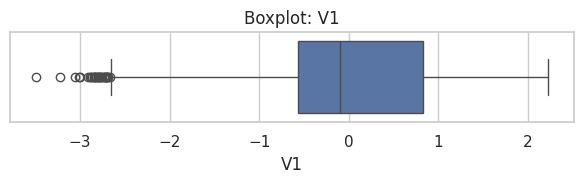

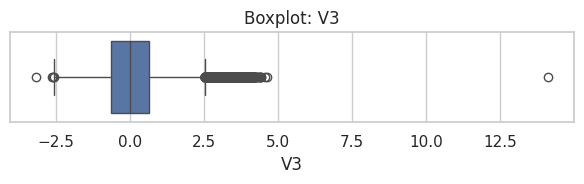

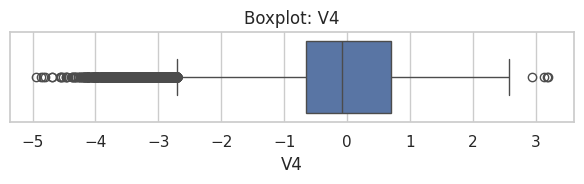

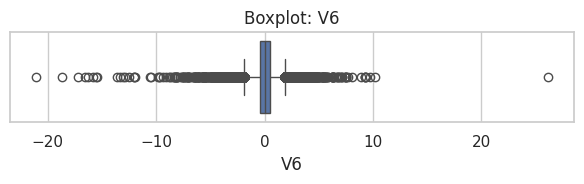

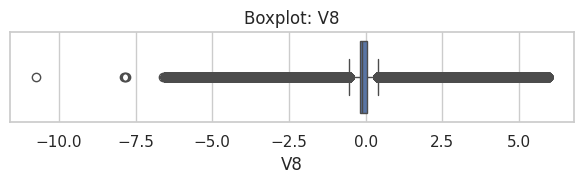

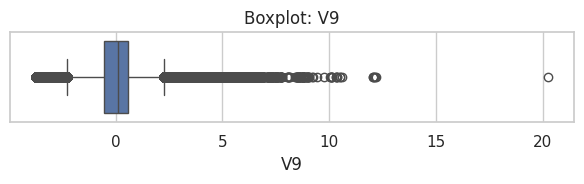

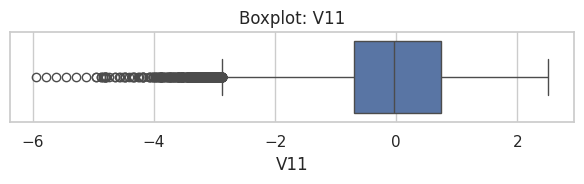

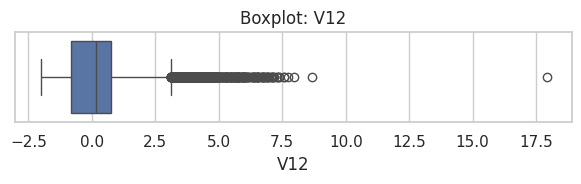

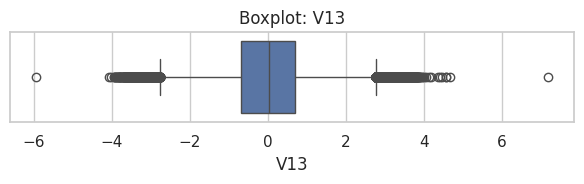

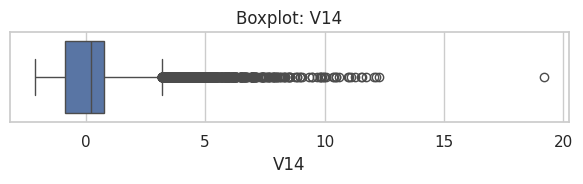

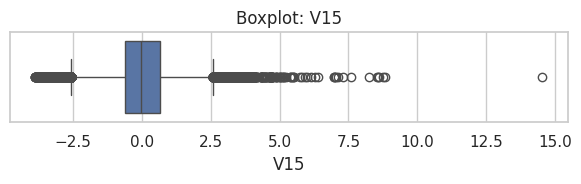

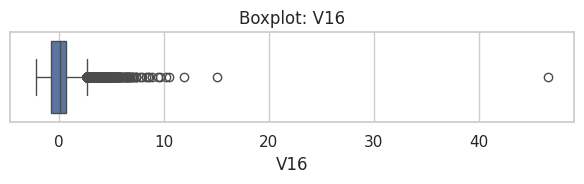

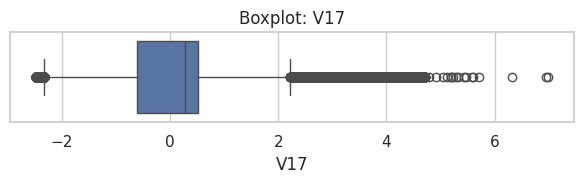

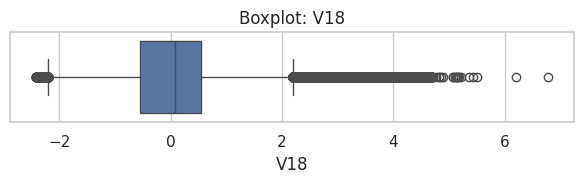

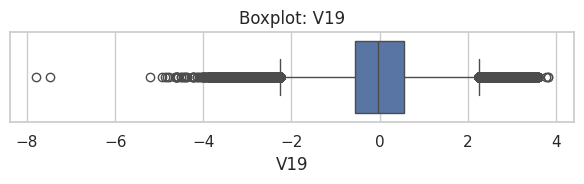

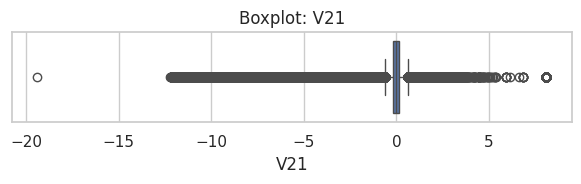

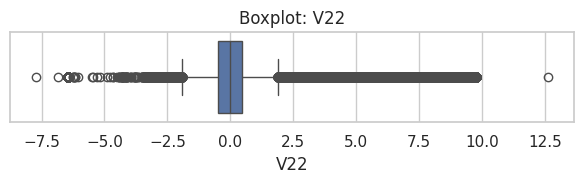

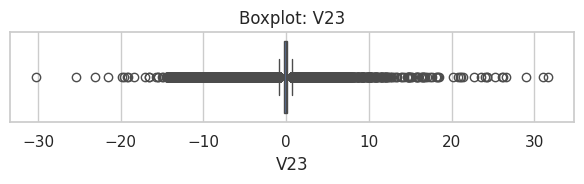

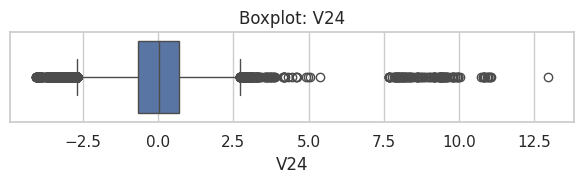

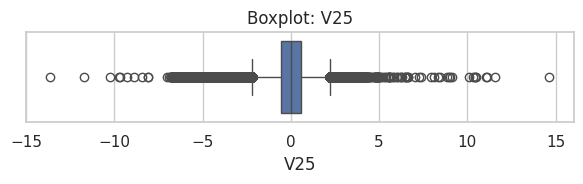

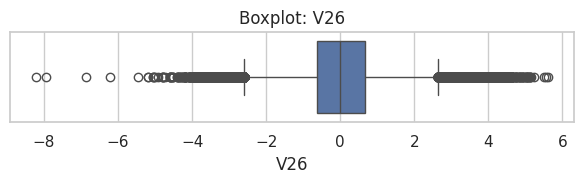

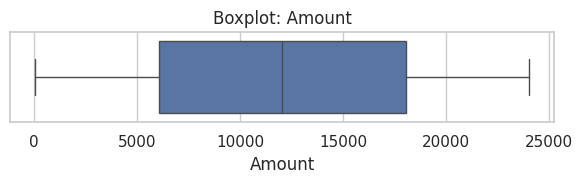

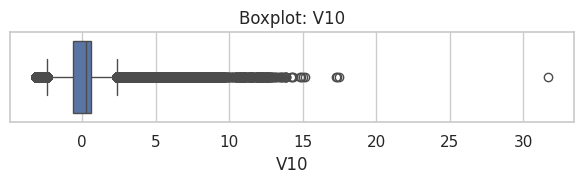

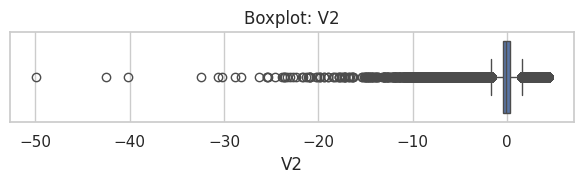

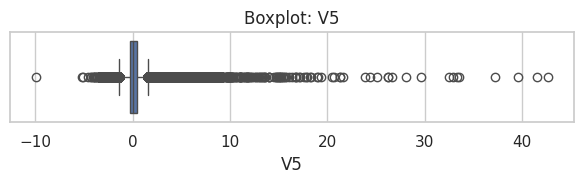

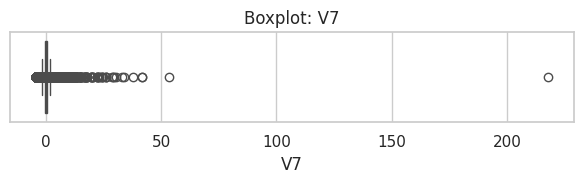

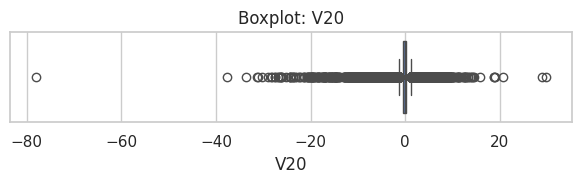

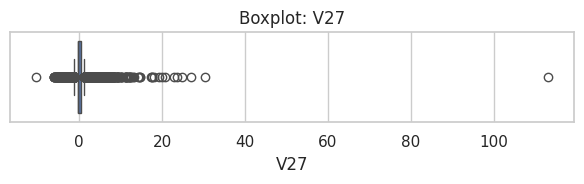

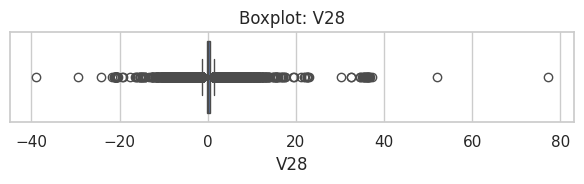

In [22]:
# ------------------------------
# 1. Visualize with Boxplots
# ------------------------------
def plot_boxplots(df, cols):
    for col in cols:
        plt.figure(figsize=(6, 2))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot: {col}')
        plt.tight_layout()
        plt.show()

plot_boxplots(X, numerical_features)

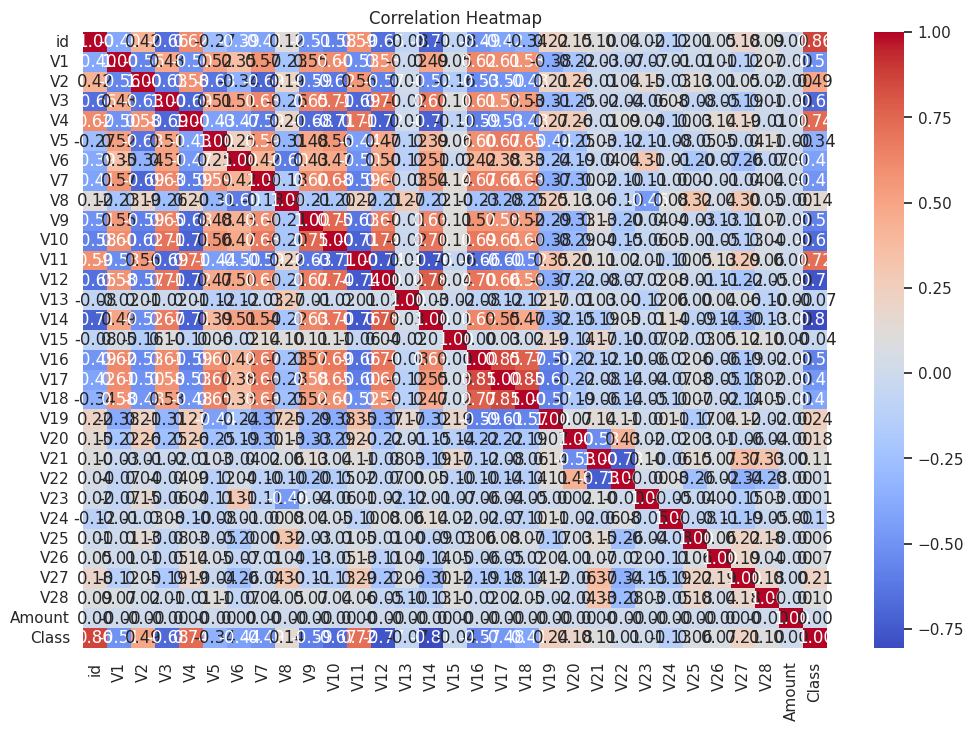

In [8]:
#  Correlation Heatmap
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# 2. Preprocess the Data.
- Split data into training, validation, and test sets
- Handle missing values if needed.
- Encode categorical variables if needed.


## 2.2 Split data into training dataset and testing dataset

In [23]:
# Preprocessing & 
X, y = load_and_preprocess(data_path)
X = X.drop(columns=['id'])

In [24]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)
X_train_copy = X_train.copy()
X_test_copy = X_test.copy()

Train shape: (454904, 29)
Test shape: (113726, 29)


In [25]:
# Train XGBoost Classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=10,
    max_depth=6,
    learning_rate=0.1,
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)
model.fit(X_train, y_train)

/mnt/c/Users/yaoqi/Qiulan/Qiulan/study/github/fraud_detection/.venv/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [12:52:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


Confusion Matrix:


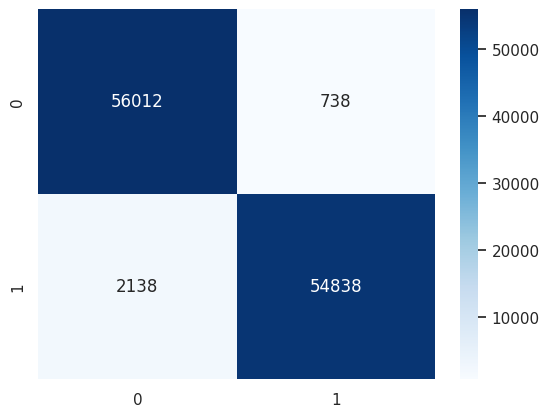


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     56750
           1       0.99      0.96      0.97     56976

    accuracy                           0.97    113726
   macro avg       0.97      0.97      0.97    113726
weighted avg       0.98      0.97      0.97    113726

ROC AUC Score: 0.9965


In [26]:
# Evaluate Model
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC Score: {roc_auc:.4f}")

<Figure size 1200x600 with 0 Axes>

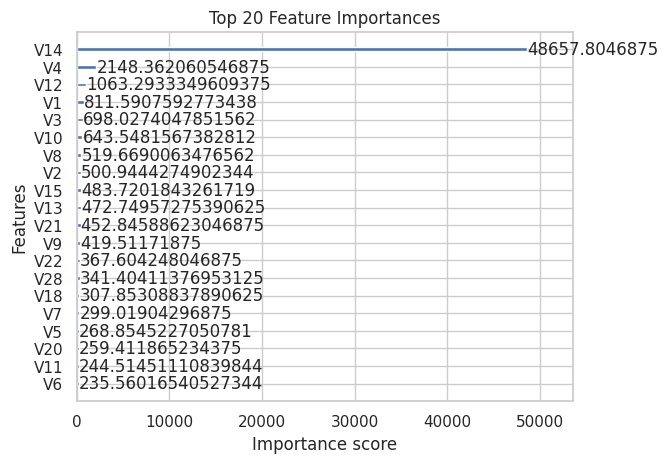

In [27]:
# Feature Importance
plt.figure(figsize=(12,6))
xgb.plot_importance(model, max_num_features=20, importance_type='gain')
plt.title("Top 20 Feature Importances")
plt.show()

In [28]:
# Cell 9: Save Model Locally
save_model(model, "../models/")
print("Model saved to ../models/model.joblib")

Model saved to ../models/model.joblib


In [29]:
# Cell 10: Load Model & Test Predictions
loaded_model = load_model("../models/model.joblib")
sample_pred = loaded_model.predict(X_test.iloc[:5])
print("Sample predictions:", sample_pred)

Sample predictions: [1 1 0 1 1]
